## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 9.7%
RAM Usage: 6.6%
Available RAM: 352.3G
Total RAM: 377.1G
52.4G


## Wandb API Query <a id="sims"></a>

Basic test

In [5]:
import wandb
from datetime import datetime, timedelta

api = wandb.Api()

project_path = "alexander-ratzan-new-york-university/gx2conn"

models = ['cge', 'gaussian_kernel', 'exponential_decay', 'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
model_groups = {'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'], 
'bilinear': ['bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank'], 
'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']}

cv_types = ['random', 'spatial']
feature_types = ['euclidean', 'transcriptome', 'transcriptome_PCA']
null_model = ['none', 'spin']
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
folds = [0, 1, 2, 3]


model = 'cge'
cv_type = 'random'
null_model = 'none'
feature_type = 'transcriptome_PCA'

time_filter = datetime.now() - timedelta(days=7)

filters = {
    "tags": {
        "$all": [
            "final_eval",
            f"model_{model}",
            f"cv_type_{cv_type}",
            f"null_model_{null_model}",
            f"feature_type_{feature_type}"
        ]
    },
    "created_at": {"$gte": time_filter.isoformat()},
    "state": "finished"
}

runs = api.runs(project_path, filters=filters, order="-created_at")
run_data = []
for run in runs:
    # Extract all metrics from final_train_metrics and final_test_metrics
    metrics = {}
    
    if 'final_train_metrics' in run.summary:
        for k, v in run.summary['final_train_metrics'].items():
            metrics[f'train_{k}'] = v
            
    if 'final_test_metrics' in run.summary:
        for k, v in run.summary['final_test_metrics'].items():
            metrics[f'test_{k}'] = v
    
    run_info = {
        'run_name': run.name,
        **metrics
    }
    run_data.append(run_info)

df = pd.DataFrame(run_data)
print(f"\nDataFrame created with {len(df)} runs")
print(f"Columns: {list(df.columns)}")


DataFrame created with 40 runs
Columns: ['run_name', 'train_geodesic_distance', 'train_inter_hemi_r', 'train_inter_network_Cerebellum_r', 'train_inter_network_Cont_r', 'train_inter_network_Default_r', 'train_inter_network_DorsAttn_r', 'train_inter_network_Limbic_r', 'train_inter_network_SalVentAttn_r', 'train_inter_network_SomMot_r', 'train_inter_network_Subcortical_r', 'train_inter_network_Vis_r', 'train_intra_network_Cerebellum_r', 'train_intra_network_Cont_r', 'train_intra_network_Default_r', 'train_intra_network_DorsAttn_r', 'train_intra_network_Limbic_r', 'train_intra_network_SalVentAttn_r', 'train_intra_network_SomMot_r', 'train_intra_network_Subcortical_r', 'train_intra_network_Vis_r', 'train_left_hemi_r', 'train_long_r', 'train_mae', 'train_mid_r', 'train_mse', 'train_pearson_r', 'train_r2', 'train_right_hemi_r', 'train_short_r', 'train_spearman_r', 'train_strong_neg_r', 'train_strong_pos_r', 'train_weak_r', 'test_geodesic_distance', 'test_inter_hemi_r', 'test_inter_network_Ce

Find individual runs

In [6]:
import wandb
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

api = wandb.Api()
project_path = "alexander-ratzan-new-york-university/gx2conn"

def fetch_and_summarize_wandb_runs(model, cv_type, null_model, feature_type, days=7):
    """
    Fetches wandb runs matching specific tags and summarizes their final train/test metrics.
    If more than 40 runs are found, keeps only one per run_name with highest test pearson_r.
    
    Args:
        model (str): Model name, e.g., 'bilinear_CM'
        cv_type (str): CV type, e.g., 'random'
        null_model (str): Null model label, e.g., 'none'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        days (int): Number of past days to search within
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
    """
    time_filter = datetime.now() - timedelta(days=days)
    
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}"
            ]
        },
        "created_at": {"$gte": time_filter.isoformat()},
        "state": "finished"
    }
    
    print(f"🔍 Fetching runs for: model={model}, cv_type={cv_type}, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        # Attempt to extract the pearson_r value (or set to NaN if missing)
        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        # Only consider runs with meaningful final_test_metrics
        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    if len(df) < 40:
        raise ValueError(f"❌ Expected 40 runs, but found {len(df)}.")

    # Deduplicate by run_name using highest test pearson_r
    df_unique = (
        df.sort_values("final_test_pearson_r", ascending=False)
          .drop_duplicates("run_name", keep="first")
    )

    if len(df_unique) != 40:
        raise ValueError(f"❌ Expected 40 unique run names, found {len(df_unique)} after deduplication.")

    # Clean and summarize
    df_clean = df_unique.drop(columns=["run_name", "run_id", "final_test_pearson_r"], errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T

    return summary_df


def fetch_and_summarize_wandb_runs_schaefer(model, null_model, feature_type, days=7):
    """
    Fetches wandb runs for cv_type='schaefer' and summarizes their final train/test metrics.
    If more than 9 runs are found, keeps only one per run_name with highest test pearson_r.
    
    Args:
        model (str): Model name
        null_model (str): Null model label, e.g., 'none' or 'spin'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        days (int): Number of past days to search within
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
    """
    time_filter = datetime.now() - timedelta(days=days)
    cv_type = "schaefer"
    
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}"
            ]
        },
        "created_at": {"$gte": time_filter.isoformat()},
        "state": "finished"
    }
    
    print(f"🔍 Fetching runs for: model={model}, cv_type=schaefer, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    if len(df) < 9:
        raise ValueError(f"❌ Expected 9 runs, but found {len(df)}.")

    # Deduplicate by run_name using highest test pearson_r
    df_unique = (
        df.sort_values("final_test_pearson_r", ascending=False)
          .drop_duplicates("run_name", keep="first")
    )

    if len(df_unique) != 9:
        raise ValueError(f"❌ Expected 9 unique run names, found {len(df_unique)} after deduplication.")

    df_clean = df_unique.drop(columns=["run_name", "run_id", "final_test_pearson_r"], errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T

    return summary_df


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_barchart(summary_dict, metric="test_pearson_r", model_groups=None, xlim=(0.1, 0.9)):
    """
    Create a horizontal bar plot of model performance with error bars, ordered by descending mean.
    """
    if model_groups is None:
        model_groups = {
            'Non-Linear': {
                'dynamic_mlp': 'Deep Neural Net',
                'shared_transformer': 'SMT',
                'shared_transformer_cls': 'SMT w/ [CLS]'
            },
            'Bilinear': {
                'bilinear_CM': 'CM',
                'bilinear_CM_PCA': 'CM (PCA)',
                'pls_bilineardecoder': 'CM (PLS)',
                'bilinear_lowrank': 'CM (Low-Rank)'},
            'Feature Based': {
                'cge': 'CGE',
                'gaussian_kernel': 'Gaussian Kernel', 
                'exponential_decay': 'Exponential Decay'
            }
        }
    else:
        # Convert list-based model_groups to dict format
        formatted_groups = {}
        for group_name, models_list in model_groups.items():
            formatted_groups[group_name] = {
                model: model.replace('_', ' ').title() 
                for model in models_list
            }
        model_groups = formatted_groups

    # Set global font size and derived sizes
    base_fontsize = 20
    plt.rcParams.update({'font.size': base_fontsize})
    label_fontsize = base_fontsize * 0.67  # ~12
    legend_fontsize = base_fontsize * 0.78  # ~14

    # Flatten model info into DataFrame
    plot_data = []
    for group_name, model_dict in model_groups.items():
        for model_key, model_display in model_dict.items():
            if model_key in summary_dict:
                df = summary_dict[model_key]
                if metric in df.columns:
                    plot_data.append({
                        "Model": model_display,
                        "Group": group_name,
                        "Mean": df.loc["mean", metric],
                        "StdErr": df.loc["stderr", metric]
                    })

    plot_df = pd.DataFrame(plot_data)

    # Sort by descending mean performance
    plot_df = plot_df.sort_values("Mean", ascending=True)

    # Plot
    plt.figure(figsize=(8, 7), dpi=300)
    ax = sns.barplot(
        data=plot_df,
        y="Model",
        x="Mean",
        hue="Group",
        dodge=False,
        palette=sns.color_palette("viridis", n_colors=8, desat=1.0)[::3],  # Using every 3rd color from 8 viridis colors for more contrast
        errorbar=None
    )

    # Add error bars manually
    for idx, (_, row) in enumerate(plot_df.iterrows()):
        ax.errorbar(
            x=row["Mean"],
            y=idx,
            xerr=row["StdErr"],
            fmt='none',
            ecolor='black',
            capsize=3,
            linewidth=2
        )

    ax.set_xlim(0.1, 1.0)
    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_xlabel("Pearson-r", fontsize=label_fontsize)
    ax.set_ylabel("")
    ax.invert_yaxis()  # best at top, worst at bottom

    # Set tick label sizes relative to base font size
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)

    # Adjust legend with relative font size
    plt.legend(fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    plt.tight_layout()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_true_vs_null_model_barchart(
    summary_true_dict,
    summary_null_dict,
    metric="test_pearson_r",
    model_groups=None,
    xlim=(0.1, 0.9),
    overlay_style="alpha"  # or "hatch"
):
    """
    Plot a horizontal bar chart comparing true vs null model performance (e.g., Pearson-r).
    Bars for true performance are solid, and null are translucent or hatched overlays.

    Args:
        summary_true_dict: dict of true result DataFrames (from fetch_and_summarize_wandb_runs)
        summary_null_dict: dict of null result DataFrames
        metric: str, metric column to visualize (e.g., 'test_pearson_r')
        model_groups: dict of grouped models with display names
        xlim: tuple, x-axis limits
        overlay_style: 'alpha' or 'hatch' for null model overlay style
    """
    if model_groups is None:
        model_groups = {
            'Non-Linear': {
                'dynamic_mlp': 'Deep Neural Net',
                'shared_transformer': 'SMT',
                'shared_transformer_cls': 'SMT w/ [CLS]'
            },
            'Bilinear': {
                'bilinear_CM': 'CM',
                'bilinear_CM_PCA': 'CM (PCA)',
                'pls_bilineardecoder': 'CM (PLS)',
                'bilinear_lowrank': 'CM (Low-Rank)'
            },
            'Feature Based': {
                'cge': 'CGE',
                'gaussian_kernel': 'Gaussian Kernel',
                'exponential_decay': 'Exponential Decay'
            }
        }

    # Set fonts
    base_fontsize = 22
    label_fontsize = base_fontsize * 0.67
    legend_fontsize = base_fontsize * 0.78
    plt.rcParams.update({'font.size': base_fontsize})

    # Flatten model info into DataFrame
    plot_data = []
    for group_name, model_dict in model_groups.items():
        for model_key, display_name in model_dict.items():
            if model_key in summary_true_dict and model_key in summary_null_dict:
                df_true = summary_true_dict[model_key]
                df_null = summary_null_dict[model_key]
                if metric in df_true.columns and metric in df_null.columns:
                    plot_data.append({
                        "Model": display_name,
                        "Group": group_name,
                        "TrueMean": df_true.loc["mean", metric],
                        "TrueStdErr": df_true.loc["stderr", metric],
                        "NullMean": df_null.loc["mean", metric],
                        "NullStdErr": df_null.loc["stderr", metric]
                    })

    plot_df = pd.DataFrame(plot_data)

    # Sort by descending true performance
    plot_df = plot_df.sort_values("TrueMean", ascending=False)
    plot_df.reset_index(drop=True, inplace=True)

    # Group color map
    unique_groups = list(model_groups.keys())
    palette = sns.color_palette("viridis", n_colors=12, desat=1.0)[2::4]  # Starting from index 3 to get lighter/bluer colors
    group_color_map = {group: color for group, color in zip(unique_groups, palette)}

    # Plot
    plt.figure(figsize=(8, 7), dpi=300)
    ax = plt.gca()

    for i in range(len(plot_df)):
        row = plot_df.iloc[i]
        y = i
        # True bar
        ax.barh(
            y=y,
            width=row["TrueMean"],
            height=0.6,
            color=group_color_map[row["Group"]],
            edgecolor="black",
            zorder=1
        )
        ax.errorbar(
            x=row["TrueMean"],
            y=y,
            xerr=row["TrueStdErr"],
            fmt='none',
            ecolor='black',
            capsize=0,
            linewidth=1,
            zorder=2
        )

        # Skip null bars for Gaussian Kernel and Exponential Decay
        if row["Model"] not in ["Gaussian Kernel", "Exponential Decay"]:
            # Null bar overlay
            if overlay_style == 'hatch':
                ax.barh(
                    y=y,
                    width=row["NullMean"],
                    height=0.6,
                    left=0,
                    edgecolor="black",
                    facecolor='none',
                    hatch="////",
                    linewidth=1,
                    zorder=3
                )
            elif overlay_style == 'alpha':
                ax.barh(
                    y=y,
                    width=row["NullMean"],
                    height=0.6,
                    left=0,
                    color="lightgray",
                    edgecolor="black",
                    alpha=0.3,
                    zorder=3
                )

            # Null error bars
            ax.errorbar(
                x=row["NullMean"],
                y=y,
                xerr=row["NullStdErr"],
                fmt='none',
                ecolor='black',
                capsize=0,
                linewidth=1,
                linestyle='--',
                zorder=4
            )

    # Final plot adjustments
    ax.set_xlim(xlim[0], xlim[1])
    xticks = np.arange(xlim[0], xlim[1] + 0.2, 0.2)  
    ax.set_xticks(xticks)
    ax.set_xlabel("Pearson-r", fontsize=label_fontsize)
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df["Model"], fontsize=label_fontsize)
    ax.invert_yaxis()  # Higher scores on top
    ax.tick_params(axis='x', labelsize=label_fontsize)

    # Custom legend
    from matplotlib.patches import Patch
    legend_patches = [Patch(facecolor=color, edgecolor='black', label=group) for group, color in group_color_map.items()]
    ax.legend(handles=legend_patches, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    plt.tight_layout()
    plt.show()

Search and plot Random

In [9]:
from collections import defaultdict

# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']


# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

model_groups = {
    'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'],
    'bilinear': ['bilinear_CM', 'bilinear_CM_PCA', 'pls_bilineardecoder', 'bilinear_lowrank'],
    'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
}

def process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict):
    """Helper function to process model/feature type combinations and populate summary dictionary"""
    print(f"Checking which model/feature type combinations return 40 runs for null_model={null_model}:\n")
    for model in models:
        feature_types = model_feature_types[model]
        for feature_type in feature_types:
            try:
                df = fetch_and_summarize_wandb_runs(model, cv_type, null_model, feature_type, days)
                
                # Handle bilinear_CM split explicitly
                if model == "bilinear_CM" and feature_type == "transcriptome_PCA":
                    summary_dict["bilinear_CM_PCA"] = df
                    print(f"✓ bilinear_CM_PCA: Successfully found 40 runs")
                elif model == "bilinear_CM" and feature_type == "transcriptome":
                    summary_dict["bilinear_CM"] = df
                    print(f"✓ bilinear_CM: Successfully found 40 runs")
                else:
                    summary_dict[model] = df
                    print(f"✓ {model} with {feature_type}: Successfully found 40 runs")

            except ValueError as e:
                print(f"✗ {model} with {feature_type}: {str(e)}")
            except Exception as e:
                print(f"! {model} with {feature_type}: Unexpected error: {str(e)}")

cv_type = 'random'
null_model = 'none'
days = 4
# Store summary DataFrames
summary_dict_random = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_random)

cv_type = 'random'
null_model = 'spin'
days = 4

# Store summary DataFrames
summary_dict_random_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_random_spin)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=random, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=random, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=random, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with transcript

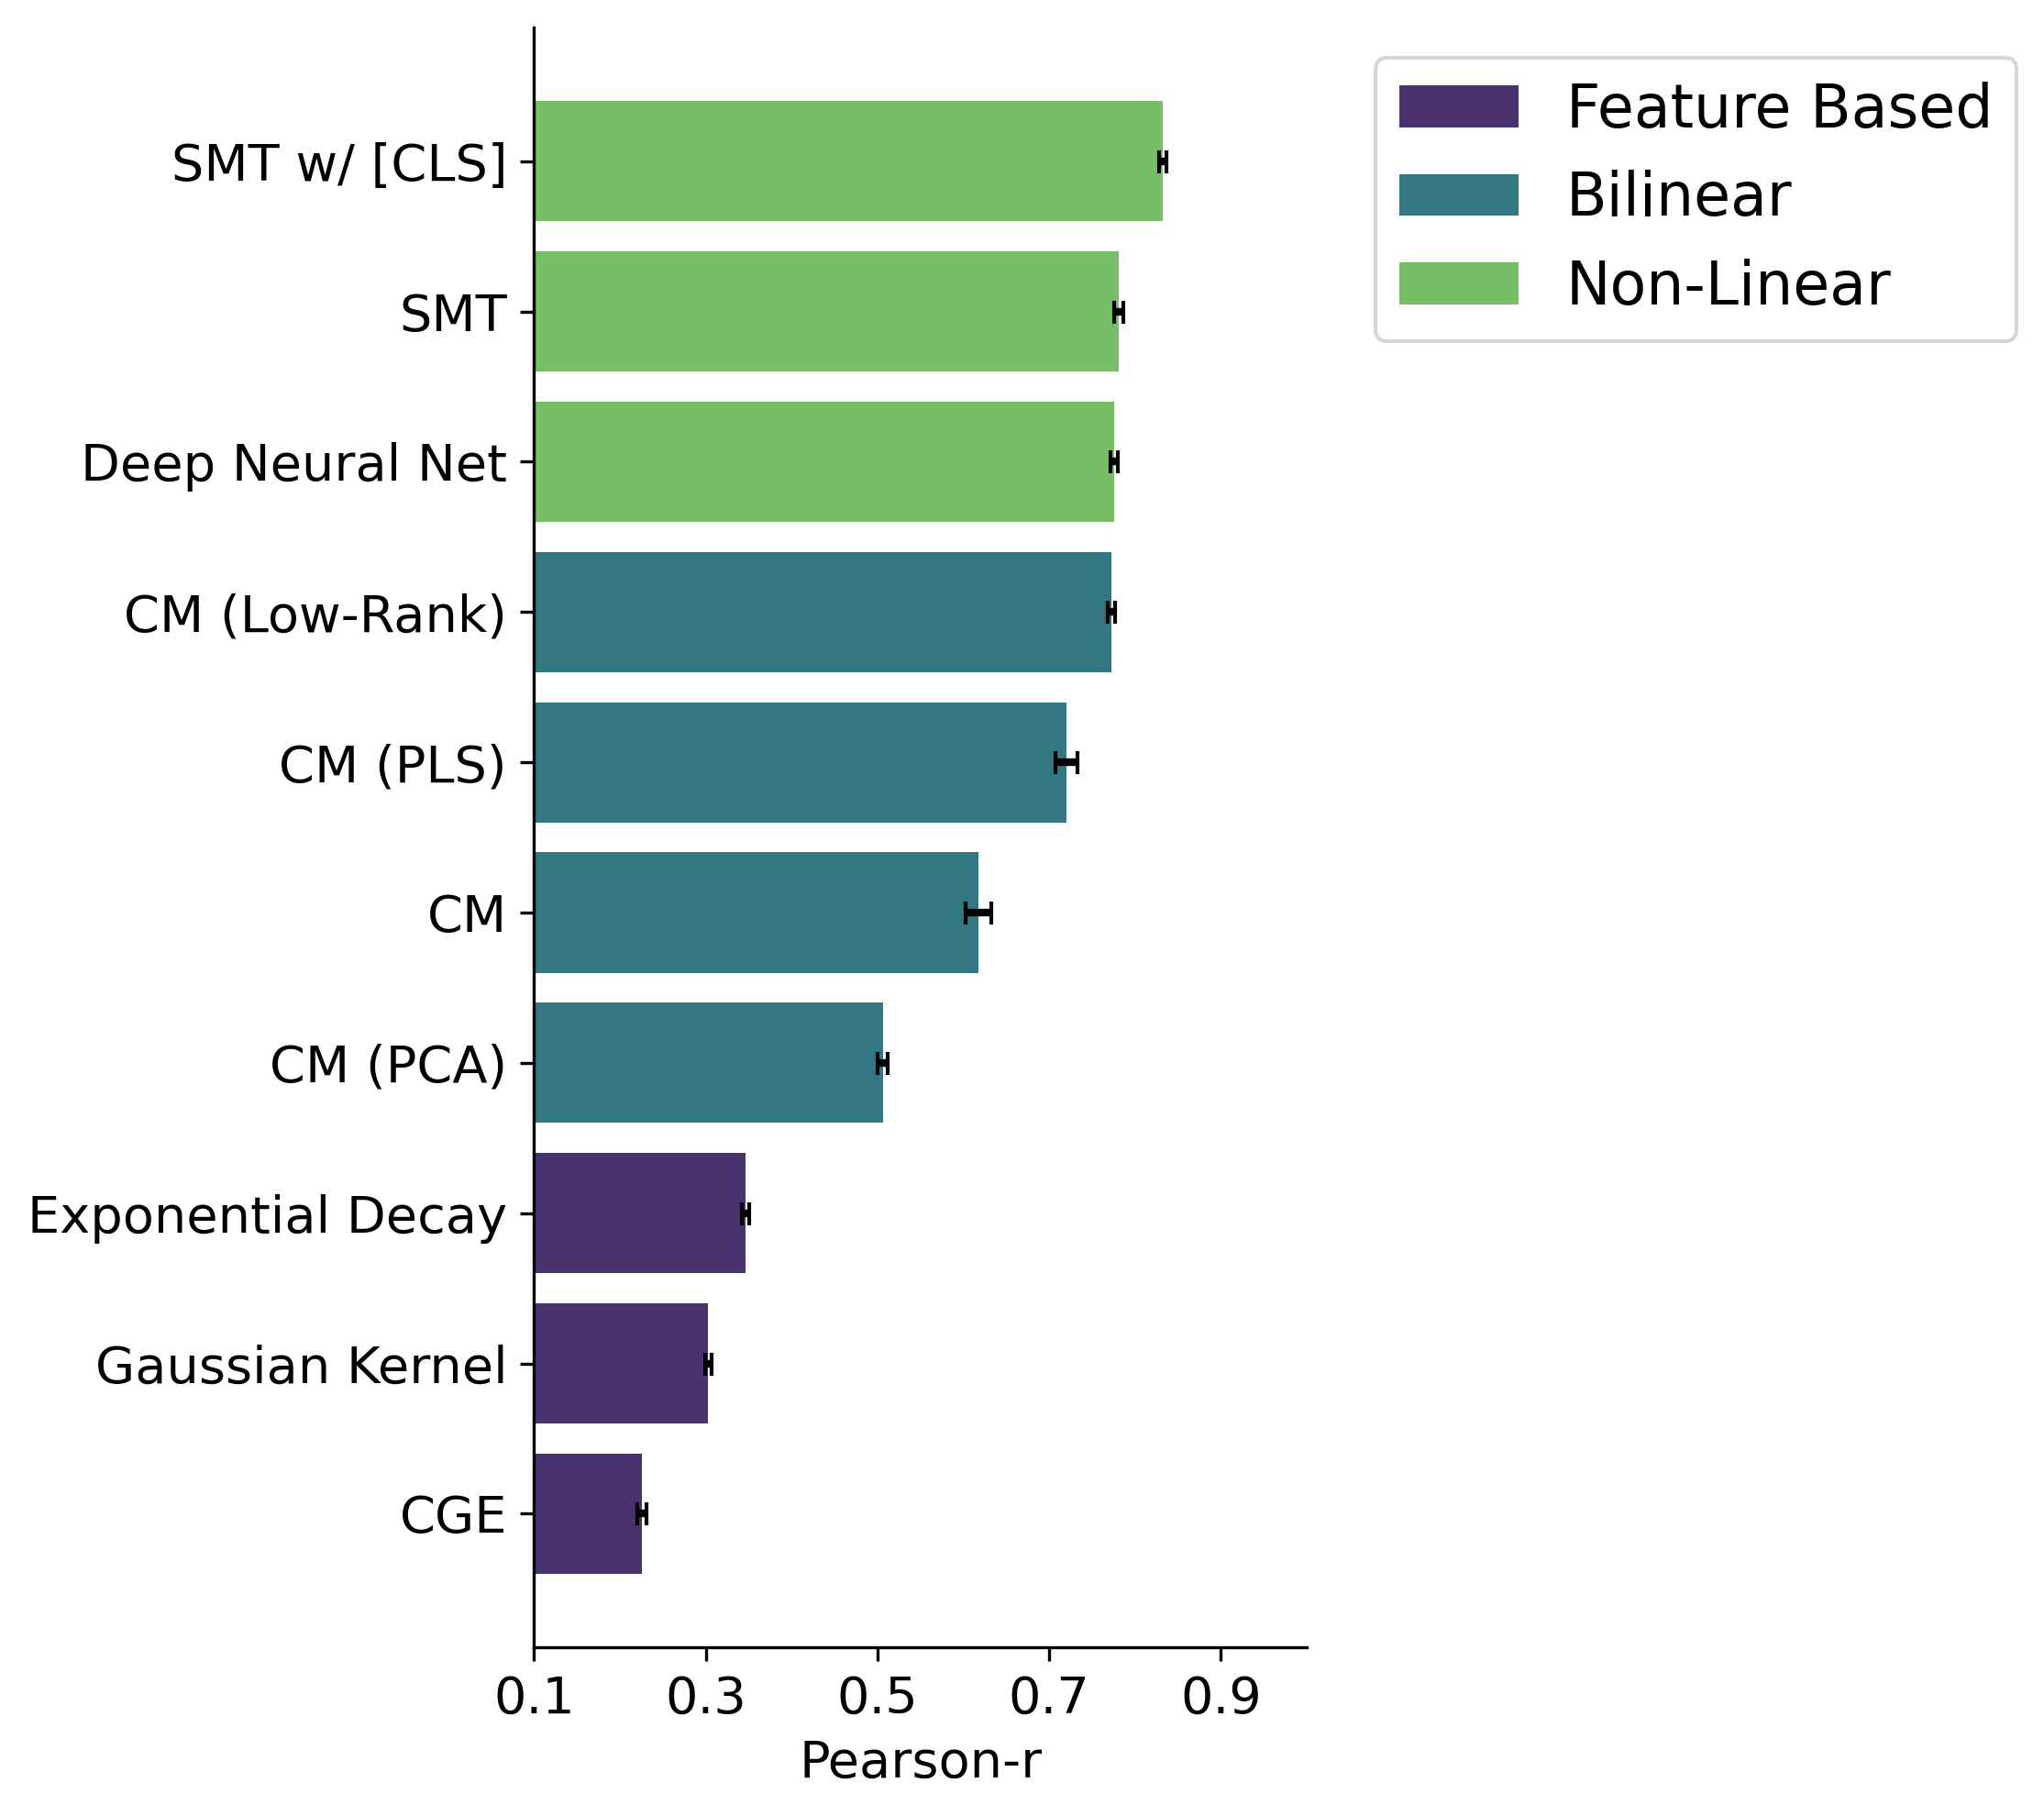

In [10]:
plot_model_barchart(summary_dict_random, metric="test_pearson_r")

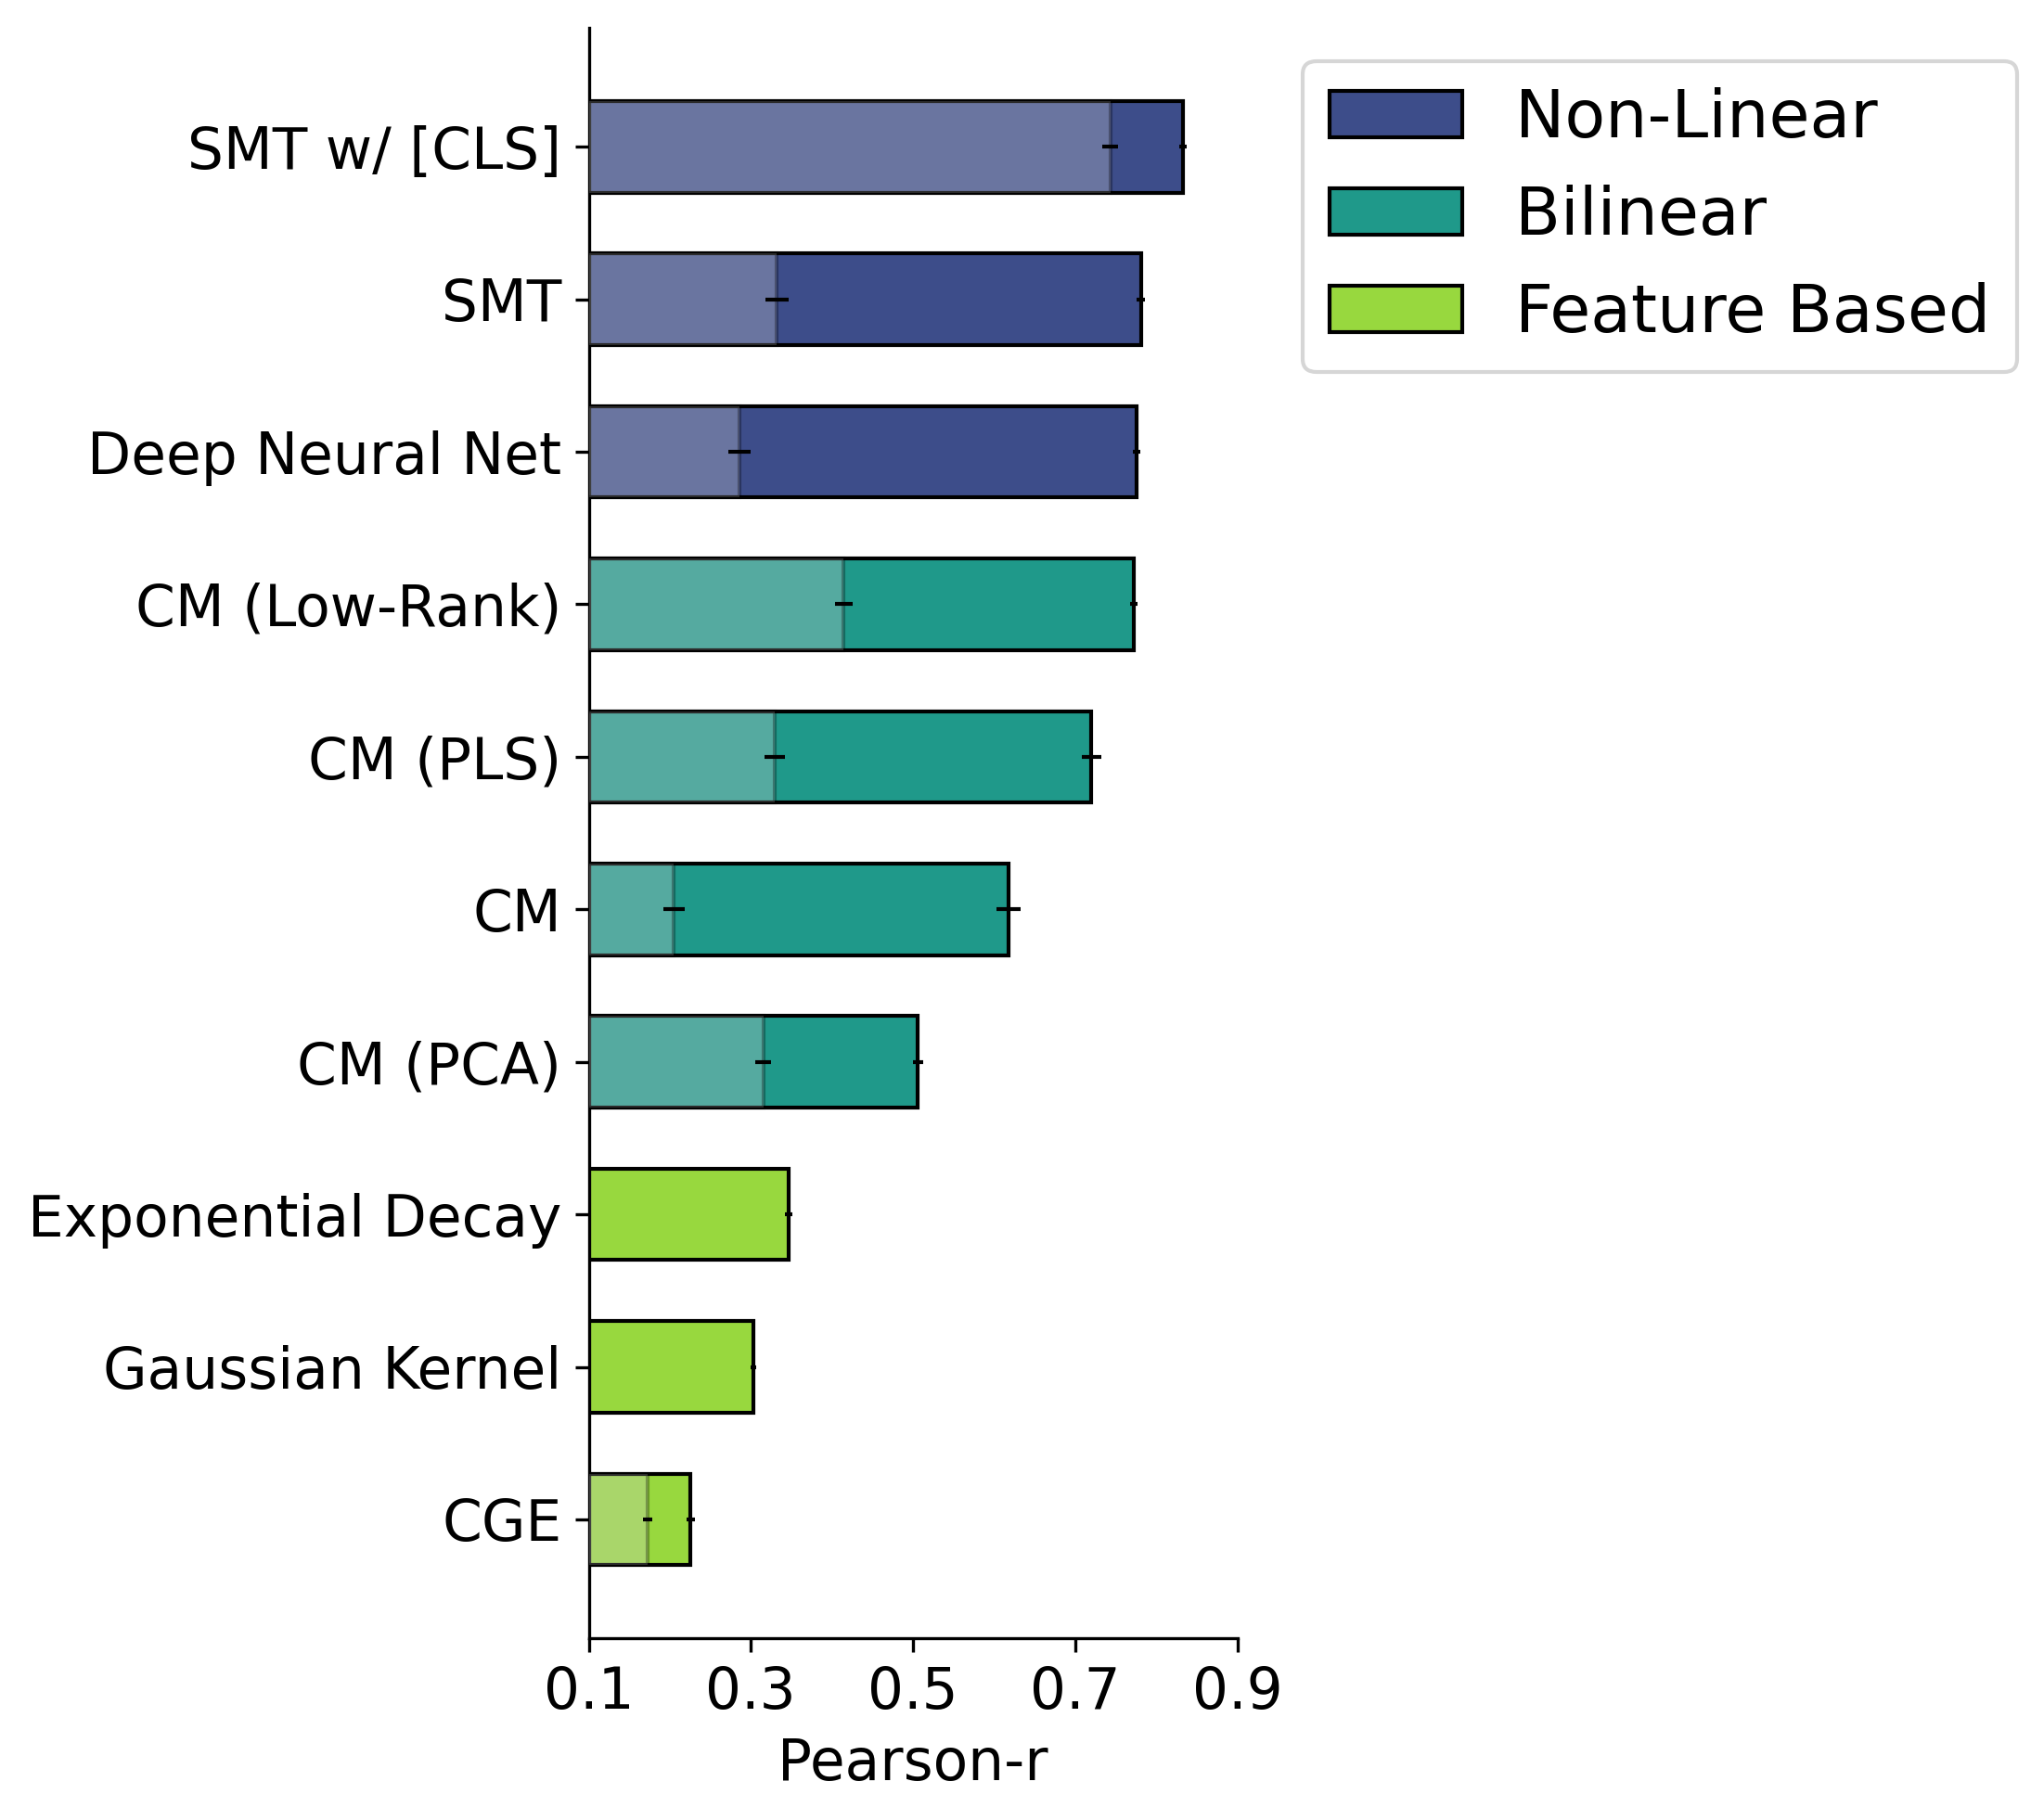

In [169]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Search and plot spatial

In [11]:
from collections import defaultdict

cv_type = 'spatial'
null_model = 'none'
days = 3

# Store summary DataFrames
summary_dict_spatial = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_spatial)


cv_type = 'spatial'
null_model = 'spin'
days = 3

# Store summary DataFrames
summary_dict_spatial_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_spatial_spin)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA


✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=spatial, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=spatial, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with transcriptome: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ bilinear_lowrank with transcriptome

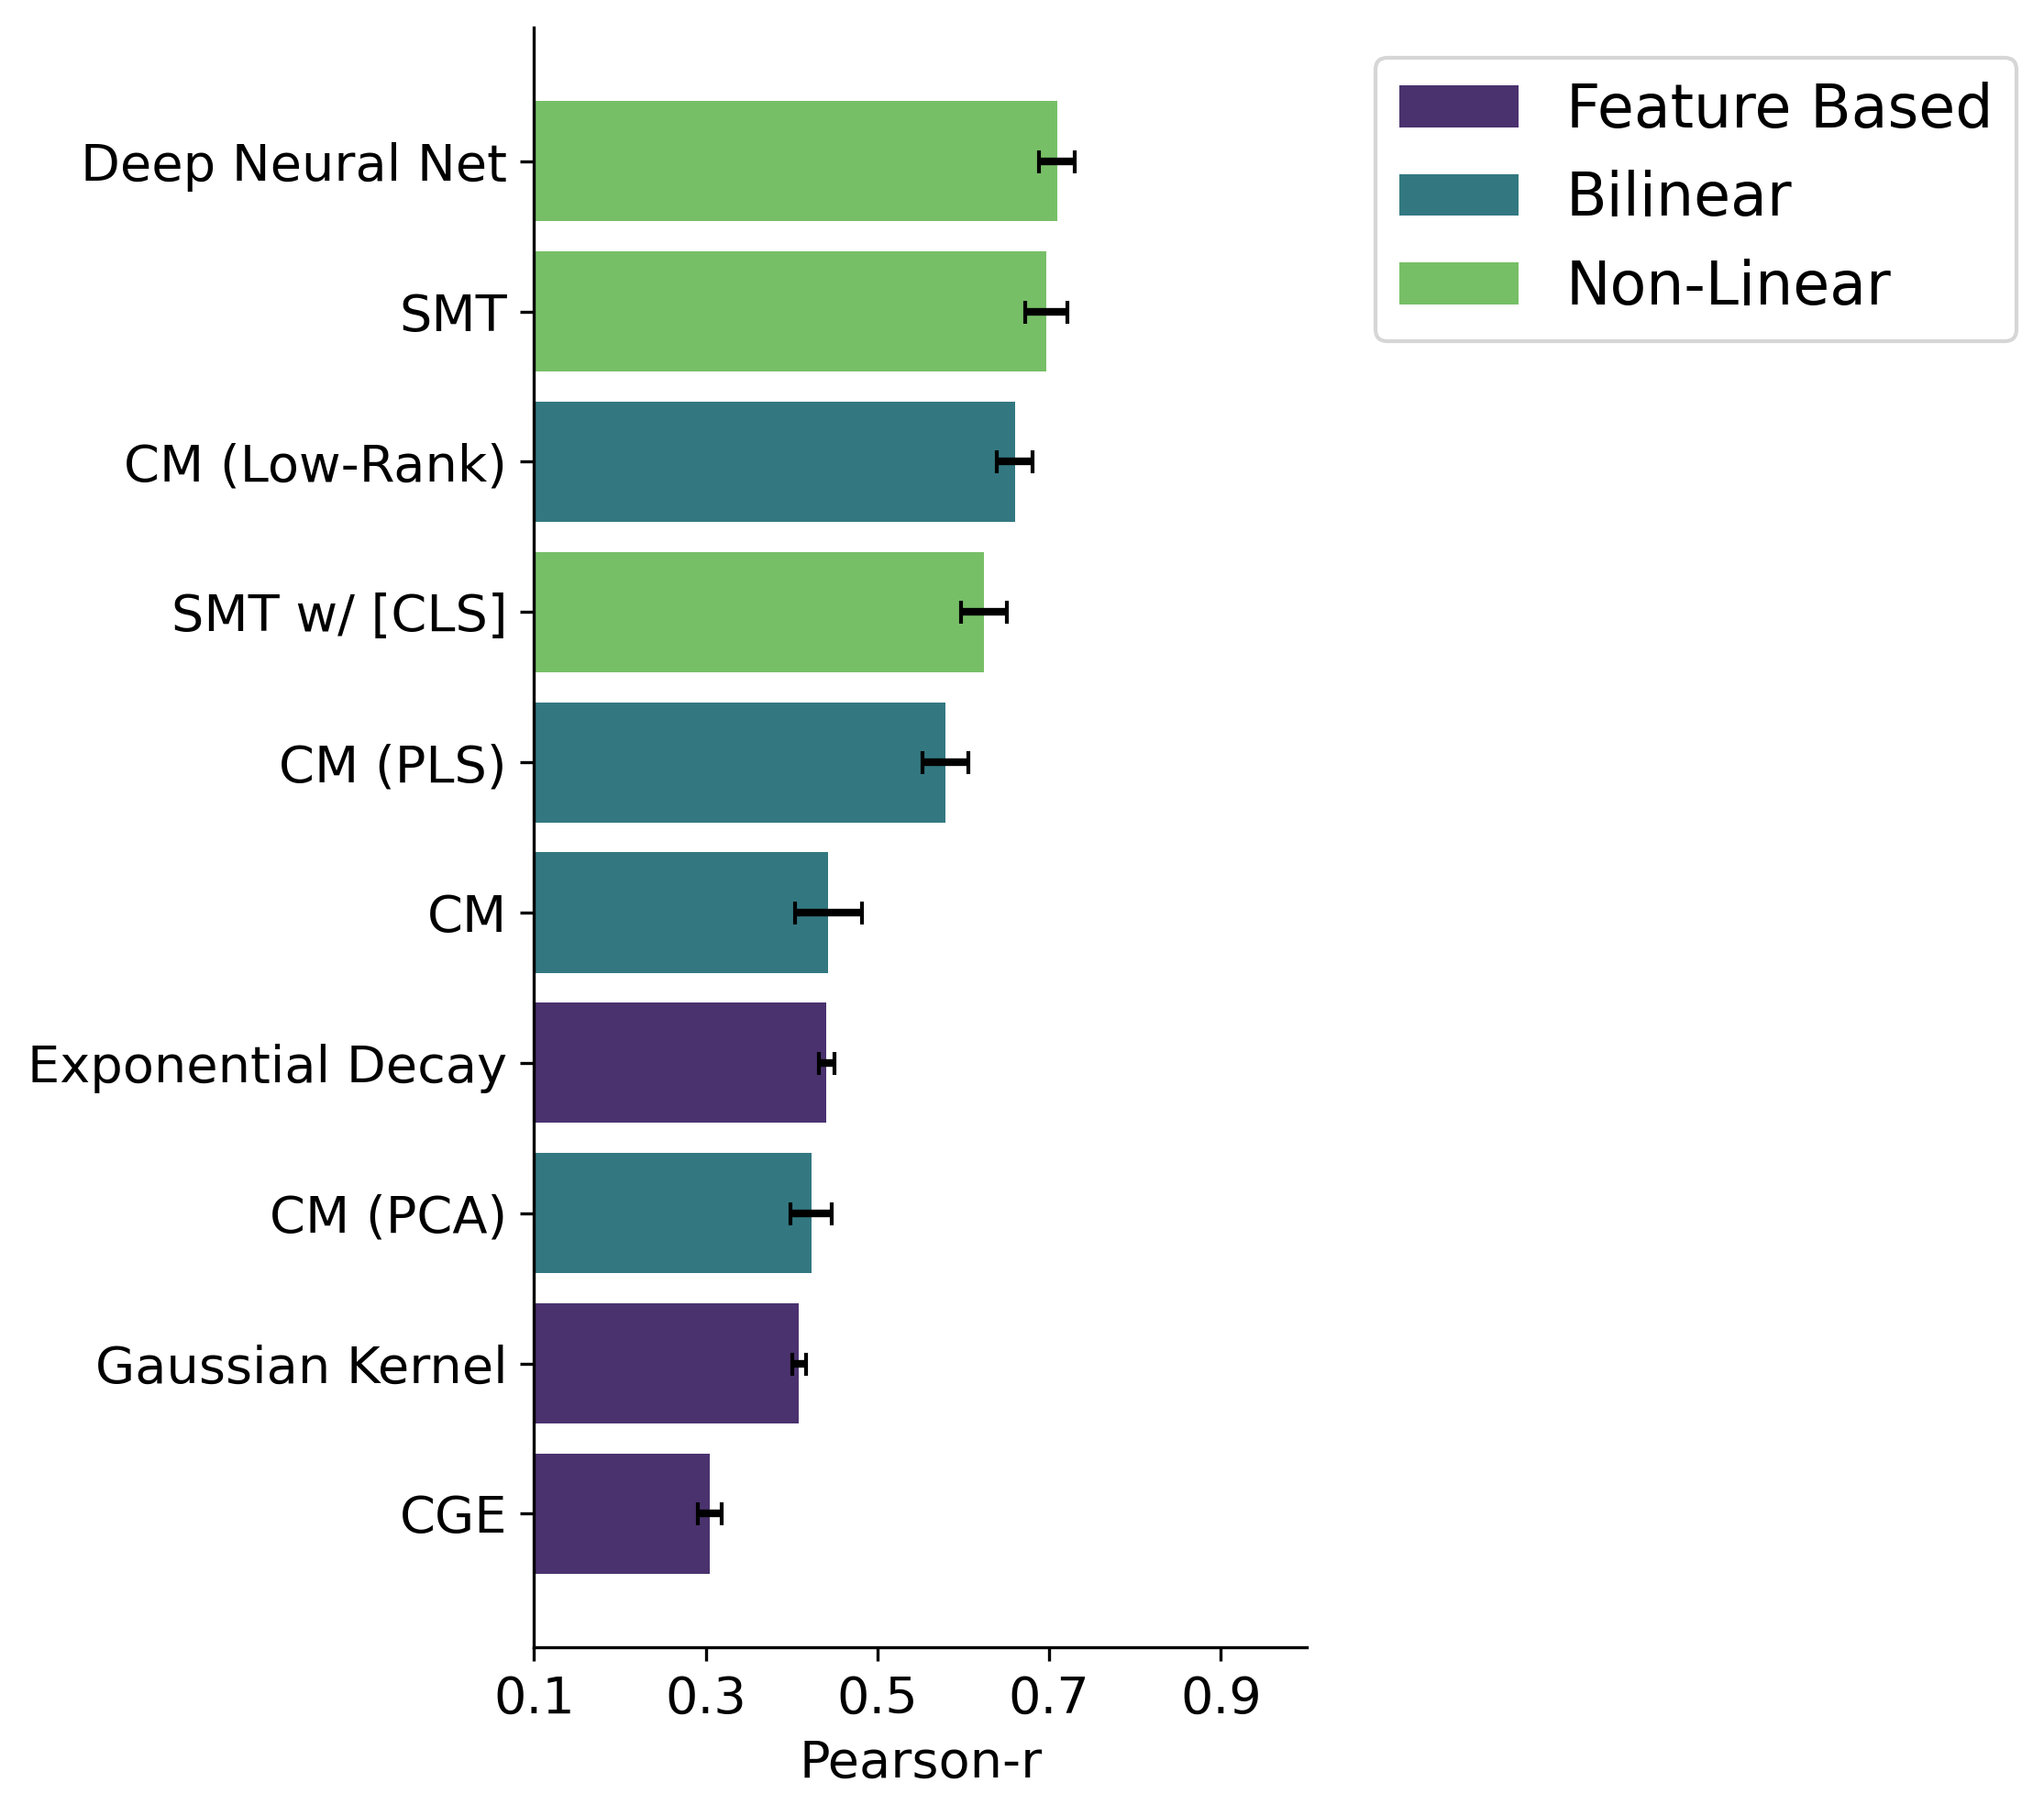

In [12]:
plot_model_barchart(summary_dict_spatial, metric="test_pearson_r")

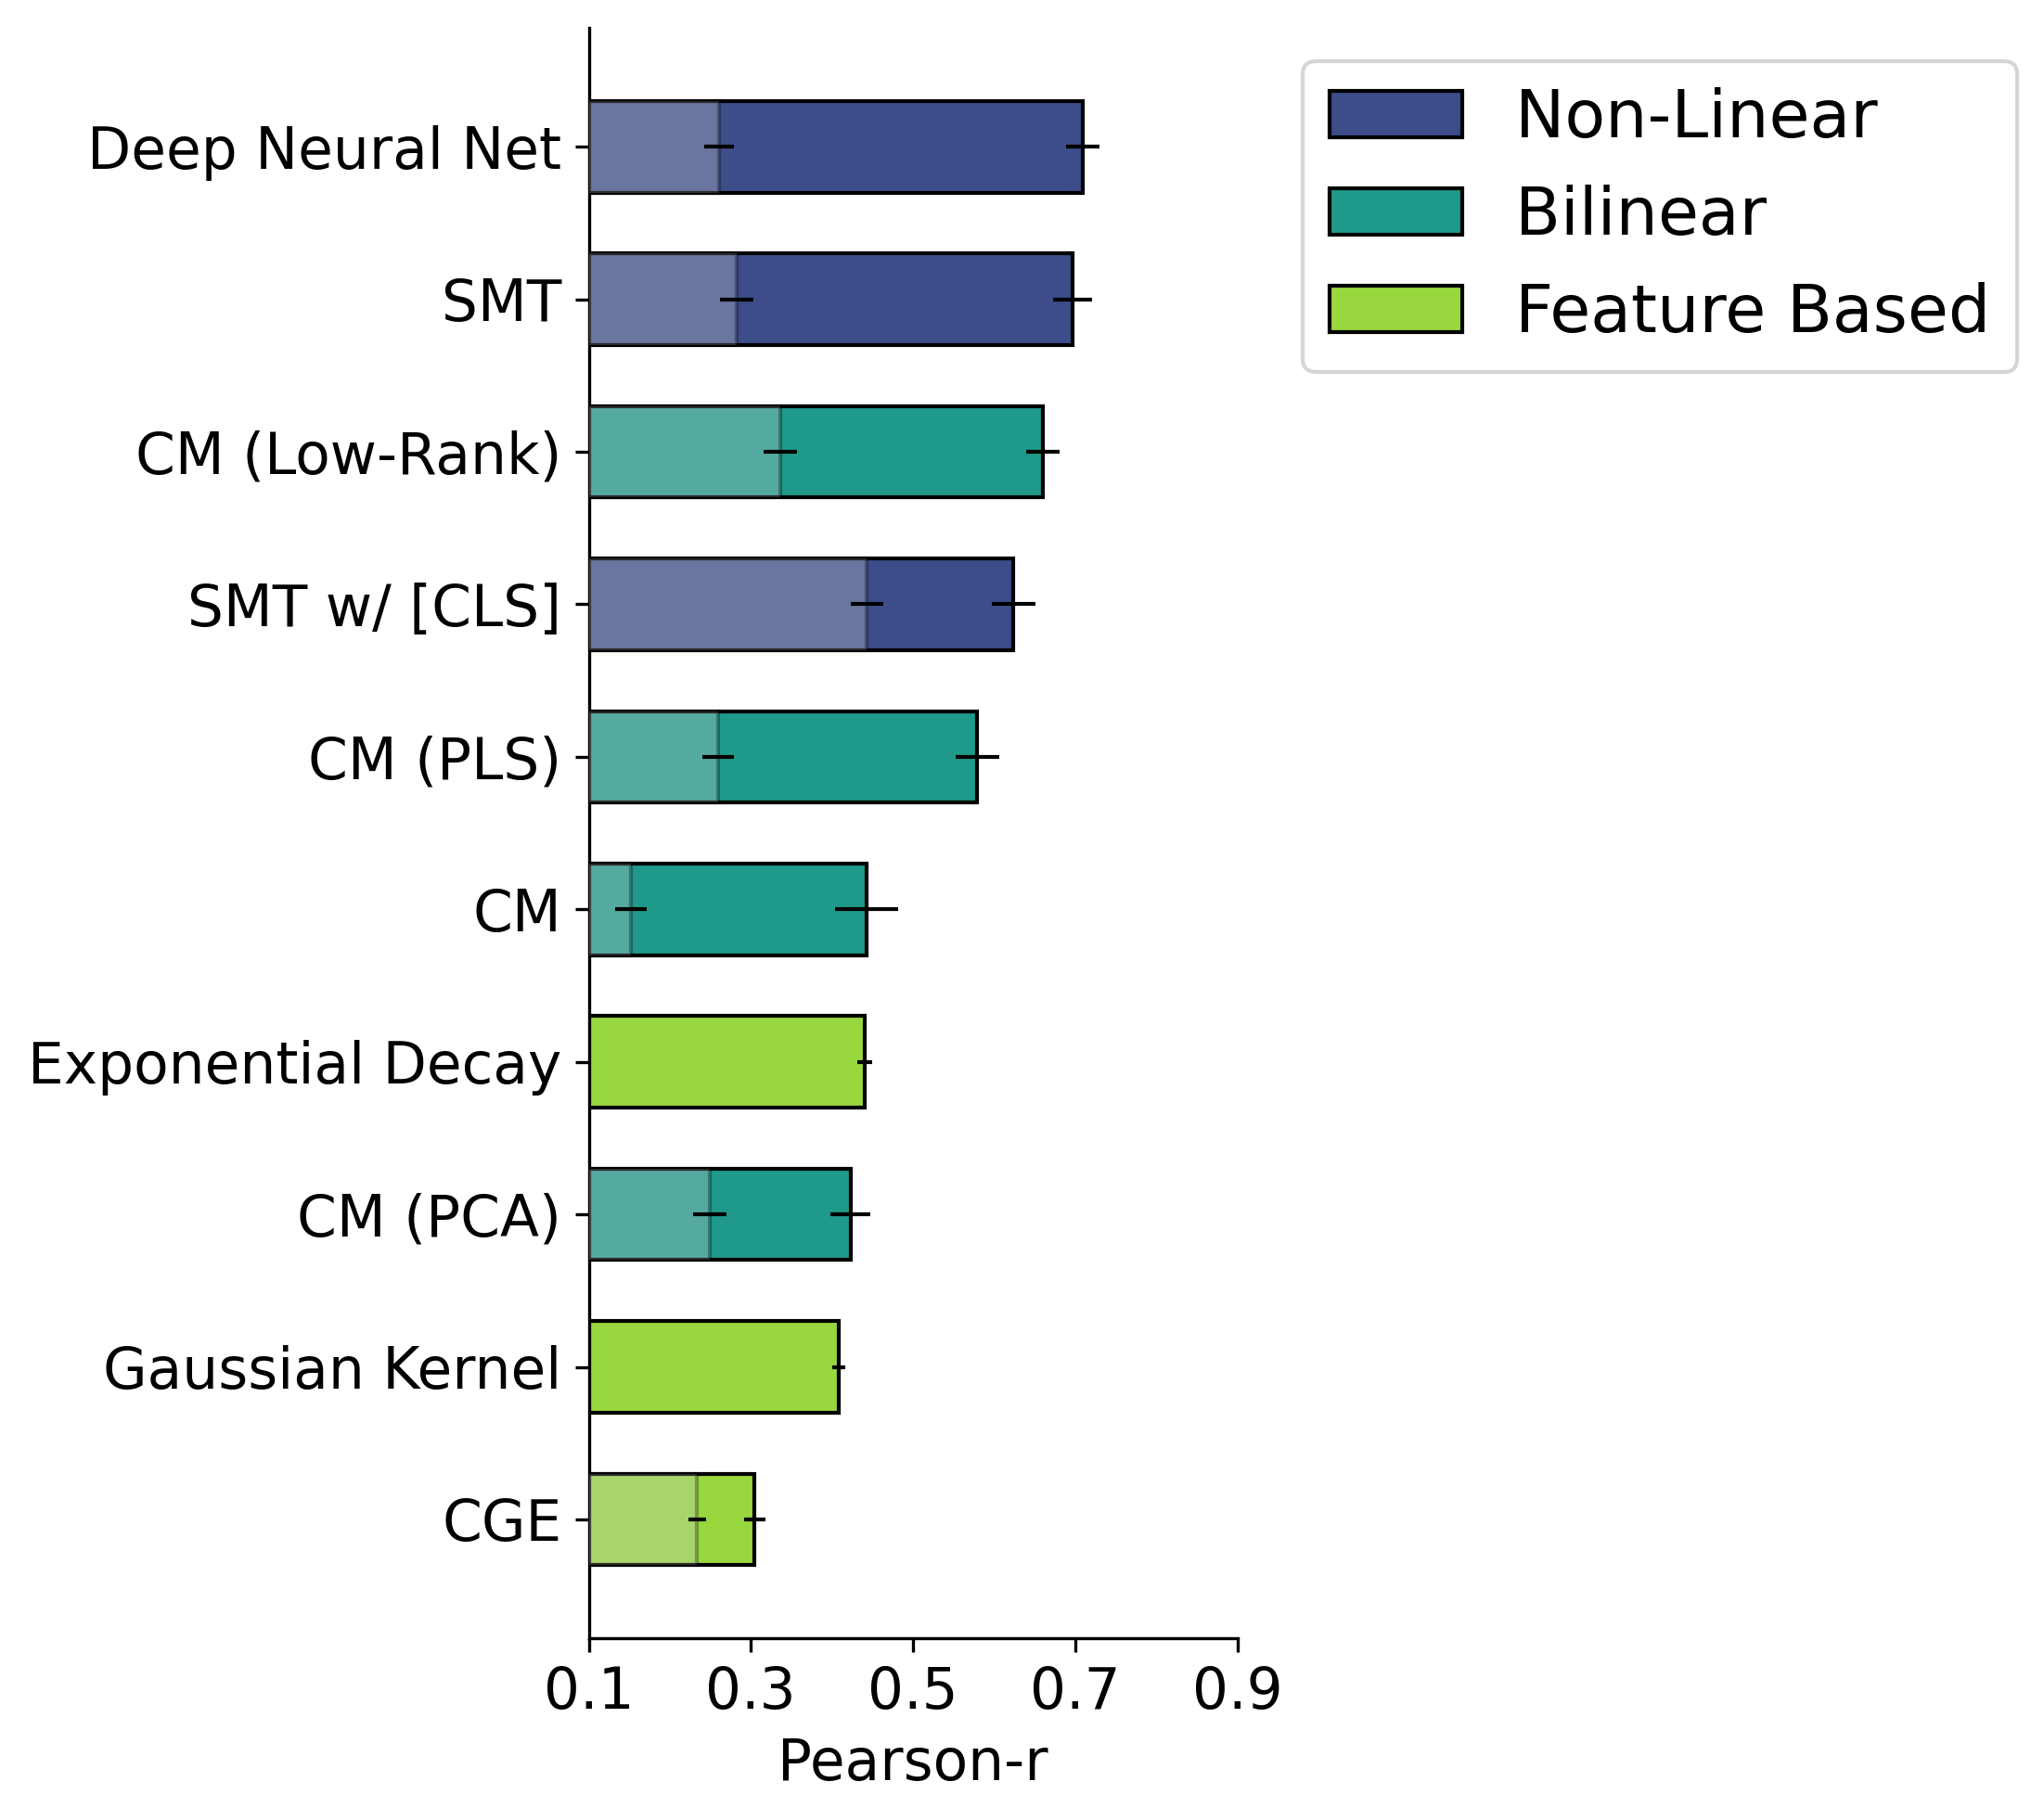

In [13]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

Search and plot Schaefer

In [ ]:
def process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict):
    """Helper function to process model/feature type combinations and populate summary dictionary"""
    print(f"Checking which model/feature type combinations return 9 runs for null_model={null_model}:\n")
    for model in models:
        feature_types = model_feature_types[model]
        for feature_type in feature_types:
            try:
                df = fetch_and_summarize_wandb_runs_schaefer(model, null_model, feature_type, days)
                
                # Handle bilinear_CM split explicitly
                if model == "bilinear_CM" and feature_type == "transcriptome_PCA":
                    summary_dict["bilinear_CM_PCA"] = df
                    print(f"✓ bilinear_CM_PCA: Successfully found 9 runs")
                elif model == "bilinear_CM" and feature_type == "transcriptome":
                    summary_dict["bilinear_CM"] = df
                    print(f"✓ bilinear_CM: Successfully found 9 runs")
                else:
                    summary_dict[model] = df
                    print(f"✓ {model} with {feature_type}: Successfully found 9 runs")

            except ValueError as e:
                print(f"✗ {model} with {feature_type}: {str(e)}")
            except Exception as e:
                print(f"! {model} with {feature_type}: Unexpected error: {str(e)}")


In [36]:
from collections import defaultdict

cv_type = 'schaefer'
null_model = 'none'
days = 3

# Store summary DataFrames
summary_dict_schaefer = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_schaefer)


cv_type = 'schaefer'
null_model = 'spin'
days = 3

# Store summary DataFrames
summary_dict_schaefer_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_schaefer_spin)

Checking which model/feature type combinations return 9 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=schaefer, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 9 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=schaefer, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 9 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=schaefer, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

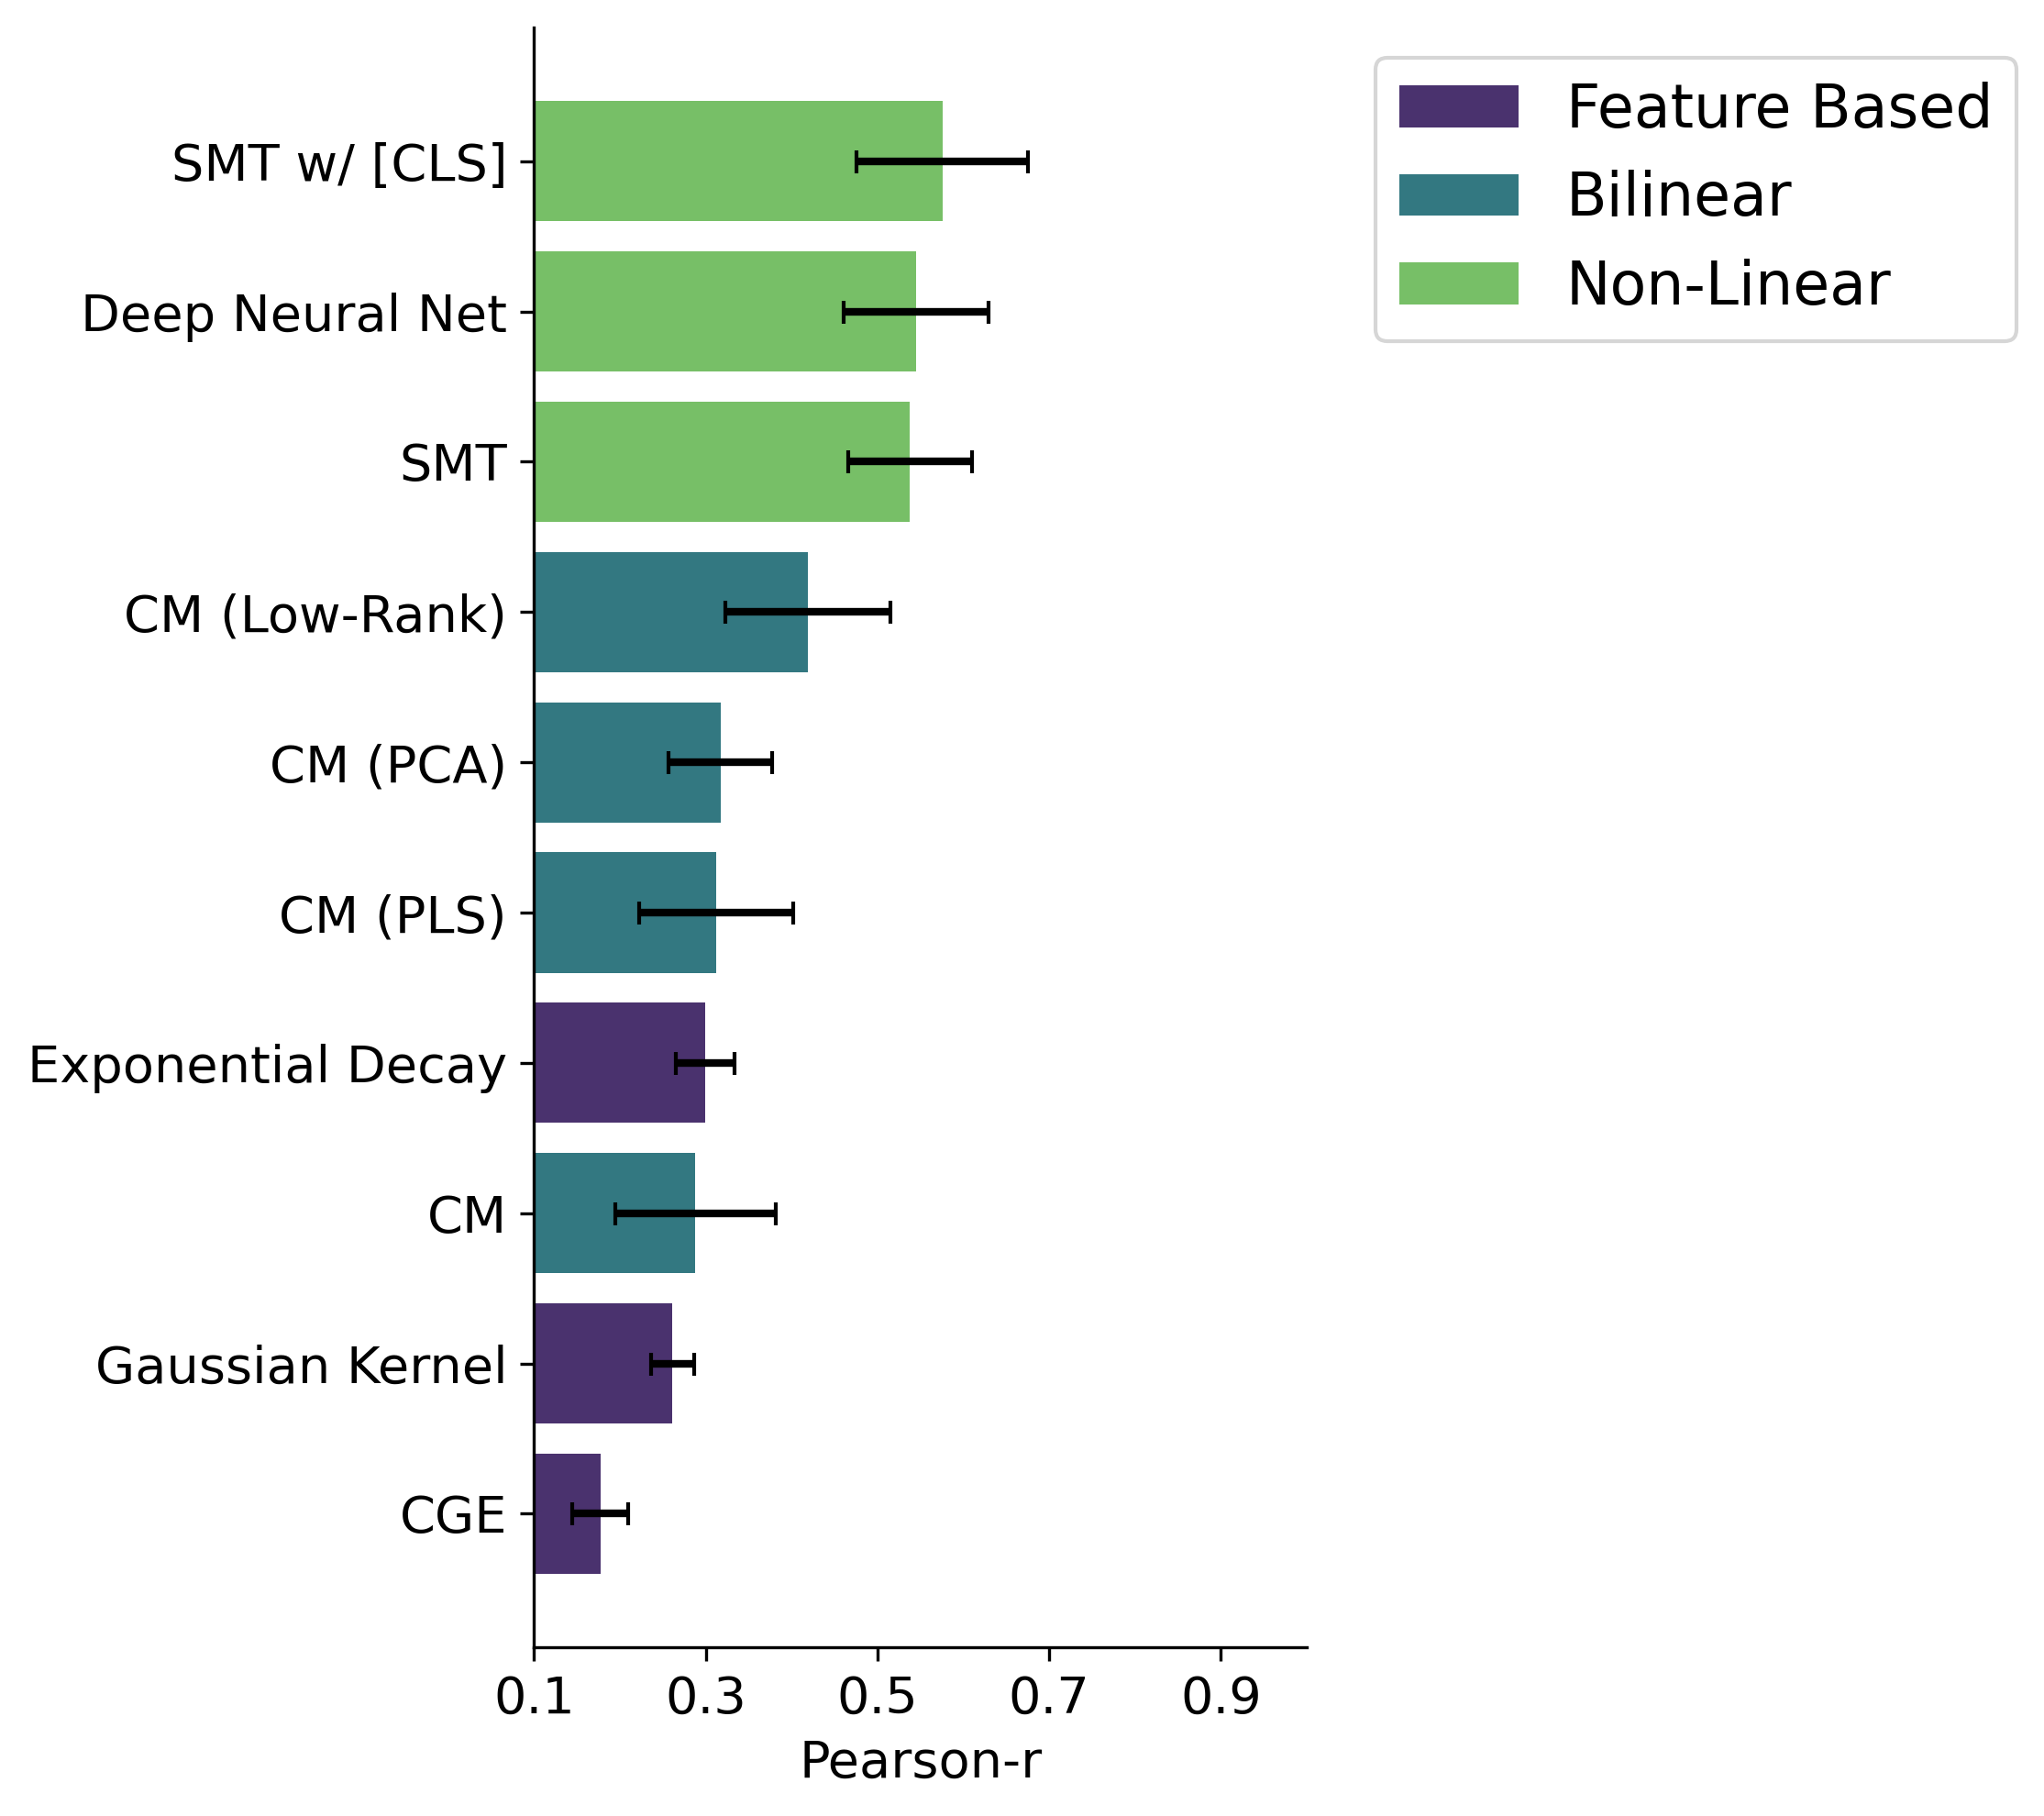

In [39]:
plot_model_barchart(summary_dict_schaefer, metric="test_pearson_r")

Continue from here with weighted averaging for schaefer plot... 